In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def find_motion_segments(df, motion_threshold=0.1, min_duration=5):
   
   # Initialize an empty list to store motion segments
   motion_segments = []
   total_motion_duration = 0
   i = 0
   while i < len(df):
       # Check if current row starts a potential motion segment
       if df['rolling_mean_motion_intensity'].iloc[i] > motion_threshold:
           start_time = df['time'].iloc[i]
           segment_start_index = i
           
           # Find the end of this motion segment
           while (i < len(df) and 
                  df['rolling_mean_motion_intensity'].iloc[i] > motion_threshold):
               i += 1
           
           end_time = df['time'].iloc[i-1]
           segment_duration = end_time - start_time
           
           # Check if segment duration meets minimum requirement
           if end_time - start_time >= min_duration:
               motion_segments.append({
                   'time_start': time.strftime('%H:%M:%S', time.gmtime(start_time)),
                   'time_end': time.strftime('%H:%M:%S', time.gmtime(end_time)),
                   'mean_motion_intensity': df['mean_motion_intensity'].iloc[segment_start_index:i].mean()
               })
               total_motion_duration += segment_duration
       
       i += 1
   
   print(f"Total motion duration: {time.strftime('%H:%M:%S', time.gmtime(total_motion_duration))}")
   return pd.DataFrame(motion_segments)

In [3]:
def extract_video_segments(input_path, output_path, segments):
   
   # Create a temporary directory for segments
   os.makedirs('temp_segments', exist_ok=True)
   # Extract individual segments
   segment_files = []
   for index, row in segments.iterrows():
       segment_path = f'temp_segments/segment_{index}.mp4'
       segment_cmd = f'ffmpeg -i {input_path} -ss {row["time_start"]} -to {row["time_end"]} -c copy {segment_path}'
       os.system(segment_cmd)
       segment_files.append(segment_path)
   
   # Create segment list file
   with open('temp_segments/segment_list.txt', 'w') as f:
       for seg_file in segment_files:
           f.write(f"file '{os.path.abspath(seg_file)}'\n")
   
   # Concatenate segments
   concat_cmd = f'ffmpeg -f concat -safe 0 -i temp_segments/segment_list.txt -c copy {output_path}'
   os.system(concat_cmd)
   
   # Clean up temporary files and directory
   os.system('rm -r temp_segments')

In [4]:
motion_intensity = pd.read_csv("motion_intensity.csv", index_col = 0)

In [5]:
motion_intensity

,time,mean_motion_intensity,median_motion_intensity,motion_std_dev
frame,,,,
0,0.000000,0.004121,0.000003,0.043590
1,0.033333,0.005321,0.000004,0.056238
2,0.066667,0.004868,0.000002,0.071566
3,0.100000,0.009293,0.000002,0.130844
4,0.133333,0.011318,0.000002,0.182909
...,...,...,...,...
105415,3513.833333,0.016044,0.000005,0.122833
105416,3513.866667,0.009734,0.000004,0.124589
105417,3513.900000,0.010298,0.000003,0.116213


In [6]:
#plt.plot(motion_intensity['time'], motion_intensity['mean_motion_intensity'])

filtered_motion = motion_intensity[motion_intensity['mean_motion_intensity'] < 1]
filtered_motion

,time,mean_motion_intensity,median_motion_intensity,motion_std_dev
frame,,,,
0,0.000000,0.004121,0.000003,0.043590
1,0.033333,0.005321,0.000004,0.056238
2,0.066667,0.004868,0.000002,0.071566
3,0.100000,0.009293,0.000002,0.130844
4,0.133333,0.011318,0.000002,0.182909
...,...,...,...,...
105415,3513.833333,0.016044,0.000005,0.122833
105416,3513.866667,0.009734,0.000004,0.124589
105417,3513.900000,0.010298,0.000003,0.116213


In [7]:
filtered_motion['rolling_mean_motion_intensity'] = filtered_motion['mean_motion_intensity'].rolling(window=20).mean()
filtered_motion.dropna(inplace = True)

/var/folders/qn/5_ffggrs6rzczzyqkrnjzkc00000gn/T/ipykernel_67558/3824054410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_motion['rolling_mean_motion_intensity'] = filtered_motion['mean_motion_intensity'].rolling(window=20).mean()
/var/folders/qn/5_ffggrs6rzczzyqkrnjzkc00000gn/T/ipykernel_67558/3824054410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_motion.dropna(inplace = True)


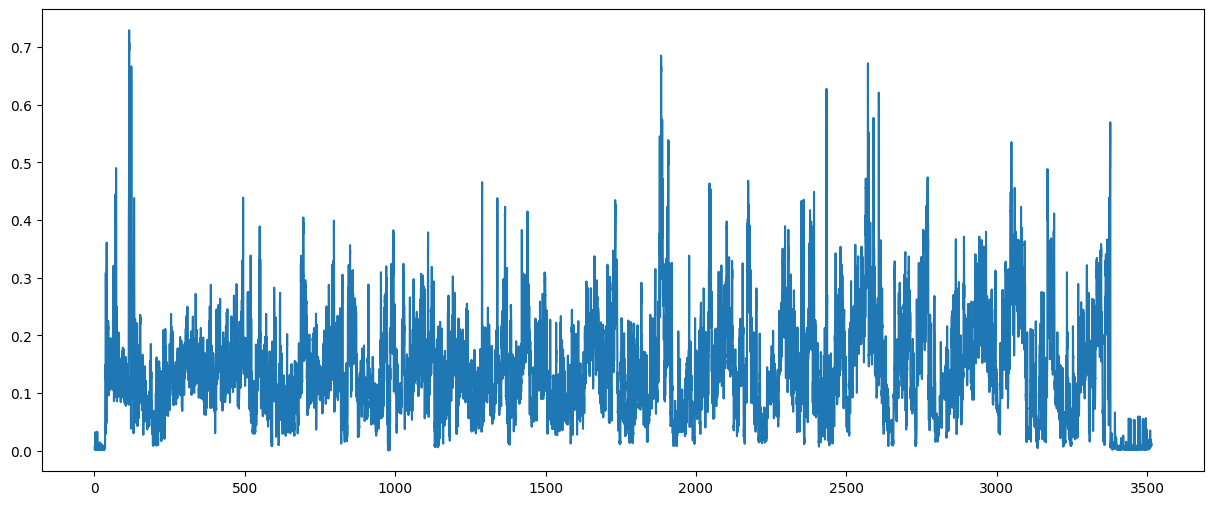

In [8]:
plt.figure(figsize=(15, 6))  # Wider figure
plt.plot(filtered_motion['time'], filtered_motion['rolling_mean_motion_intensity'])

In [9]:
grouped_filtered_motion = find_motion_segments(filtered_motion)
grouped_filtered_motion[10:50]

Total motion duration: 00:24:01


,time_start,time_end,mean_motion_intensity
10,00:06:13,00:06:25,0.149632
11,00:06:31,00:06:36,0.129839
12,00:06:45,00:07:00,0.176433
13,00:07:06,00:07:12,0.145201
14,00:07:16,00:07:24,0.163821
15,00:07:31,00:07:56,0.167857
16,00:08:00,00:08:35,0.180866
17,00:09:00,00:09:13,0.190846
18,00:09:52,00:09:58,0.145036
19,00:11:28,00:11:47,0.214717


In [10]:
PATH2VID = "/Users/rusiq/Downloads/youtube_dl/katka1.mp4"
extract_video_segments(PATH2VID, "output_merged_katka1.mp4", grouped_filtered_motion)

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena